In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
parent_dir=""                   
image_dir="cropped/"

In [9]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.layers import Conv2D,Dense,BatchNormalization,UpSampling2D,Reshape,LeakyReLU,Flatten,Input,Conv2DTranspose
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from sklearn.datasets import fetch_lfw_people
from tqdm import tqdm_notebook
from time import time
from tensorflow.keras.initializers import TruncatedNormal

In [10]:
warnings.filterwarnings("ignore")

In [5]:
imgs=[]
for file in tqdm_notebook(os.listdir(image_dir)):

    img=cv2.imread(image_dir+file) 
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=img.astype("float",copy=False)   
    img=(img-127.5)/127.5
    img=cv2.resize(img,(128,128))
    imgs.append(img)
    
imgs=np.array(imgs)

In [6]:
imgs.shape

(9798, 128, 128, 3)

W0401 19:27:48.374730  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:27:48.398734  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:27:48.422700  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:27:48.442674  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:27:48.470636  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:27:48.498592  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:27:48.526553  6612 image.py:700] Clipping input data to the valid range for ims

W0401 19:27:52.564964  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:27:52.692787  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:27:52.824603  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:27:52.960418  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:27:53.096232  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:27:53.232040  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:27:53.371861  6612 image.py:700] Clipping input data to the valid range for ims

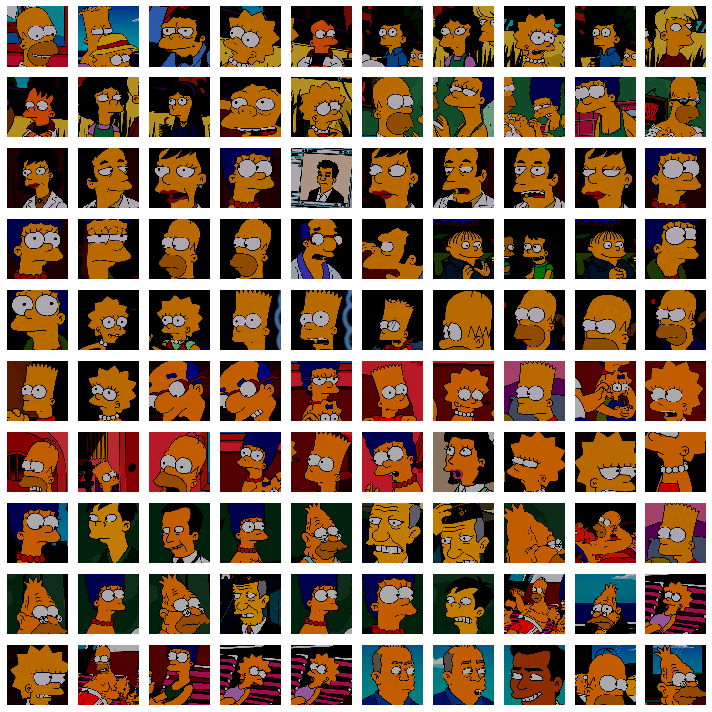

In [15]:
ax=plt.figure(figsize=(10,10))
for i in range(100): 
    ax.add_subplot(10,10,i+1)
    plt.imshow(imgs[i])

    plt.axis("off")
    plt.tight_layout()
plt.show()

In [16]:
n_epochs=200
batch_size=256
n_batches=int(imgs.shape[0]/batch_size)
noise_dim=100

opt=Adam(lr=0.0001,beta_1=0.5)

In [18]:
gen=Sequential()                                   

gen.add(Dense(4*4*128,input_shape=(noise_dim,)))
gen.add(Reshape((4,4,128)))
gen.add(LeakyReLU(0.2))
gen.add(BatchNormalization(epsilon=0.00005))
#shape of output: (4,4,128)

# gen.add(UpSampling2D((2,2)))                                        
# gen.add(Conv2D(64,(5,5),padding="same"))                             
gen.add(Conv2DTranspose(64,(5,5),strides=(2,2),padding="same")) 
gen.add(LeakyReLU(0.2))
gen.add(BatchNormalization(epsilon=0.00005))
#shape of output: (8,8,64)

# gen.add(UpSampling2D((2,2)))                                        
# gen.add(Conv2D(32,(5,5),padding="same"))                             
gen.add(Conv2DTranspose(32,(5,5),strides=(2,2),padding="same")) 
gen.add(LeakyReLU(0.2))
gen.add(BatchNormalization(epsilon=0.00005))
#shape of output: (16,16,32)

# gen.add(UpSampling2D((2,2)))                                        
# gen.add(Conv2D(16,(5,5),padding="same"))                             
gen.add(Conv2DTranspose(16,(5,5),strides=(2,2),padding="same")) 
gen.add(LeakyReLU(0.2))
gen.add(BatchNormalization(epsilon=0.00005))
#shape of output: (32,32,16)

# gen.add(UpSampling2D((2,2)))                                        
# gen.add(Conv2D(8,(5,5),padding="same"))                             
gen.add(Conv2DTranspose(8,(5,5),strides=(2,2),padding="same")) 
gen.add(LeakyReLU(0.2))
gen.add(BatchNormalization(epsilon=0.00005))
#shape of output: (64,64,8)

# gen.add(UpSampling2D((2,2)))                                         
# gen.add(Conv2D(3,(5,5),padding="same",activation="tanh"))            
gen.add(Conv2DTranspose(3,(5,5),padding="same",strides=(2,2),activation="tanh"))
gen.add(BatchNormalization(epsilon=0.00005))
#shape of output: (128,128,3)

gen.compile(optimizer=opt,loss="binary_crossentropy")
gen.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 64)          204864    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 64)         

In [19]:
disc=Sequential()                 

disc.add(Conv2D(8,(5,5),strides=2,padding="same",input_shape=(128,128,3)))       
disc.add(LeakyReLU(0.2))
#shape of output: (64,64,8)

disc.add(Conv2D(16,(5,5),strides=2,padding="same"))                            
disc.add(LeakyReLU(0.2))
#shape of output: (32,32,16)

disc.add(Conv2D(32,(5,5),strides=2,padding="same"))                        
disc.add(LeakyReLU(0.2))
#shape of output: (16,16,32)

disc.add(Conv2D(64,(5,5),strides=2,padding="same"))                       
disc.add(LeakyReLU(0.2))
#shape of output: (8,8,64)

disc.add(Conv2D(128,(5,5),strides=2,padding="same"))                           
disc.add(LeakyReLU(0.2))
#shape of output: (4,4,128)

disc.add(Flatten())
disc.add(Dense(1,activation="sigmoid"))

disc.compile(loss="binary_crossentropy",optimizer=opt)
disc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         608       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        3216      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        12832     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)         

In [21]:
disc.trainable=False

gan_input=Input(shape=(noise_dim,))
gen_img=gen(gan_input)
gan_output=disc(gen_img)

model=Model(gan_input,gan_output)
model.compile(loss="binary_crossentropy",optimizer=opt)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 128, 128, 3)       480575    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 274897    
Total params: 755,472
Trainable params: 480,073
Non-trainable params: 275,399
_________________________________________________________________


In [22]:
def show_imgs(n_samples=100):                        #n_samples is the no. of images that u want to plot
    
    noise=np.random.normal(0,1,size=(n_samples,noise_dim))
    gen_imgs=gen.predict(noise)

    ax=plt.figure(figsize=(10,10))
    for i in range(n_samples):
        plt.subplot(10,10,i+1)
        plt.imshow(gen_imgs[i])

        plt.axis("off")
        plt.tight_layout()

    plt.show()

W0401 19:33:31.215621  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:33:31.243545  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:33:31.274462  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:33:31.305386  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:33:31.341280  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:33:31.378179  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:33:31.398124  6612 image.py:700] Clipping input data to the valid range for ims

W0401 19:33:33.898190  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:33:33.984951  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:33:34.070717  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:33:34.158479  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:33:34.246239  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:33:34.337989  6612 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 19:33:34.425767  6612 image.py:700] Clipping input data to the valid range for ims

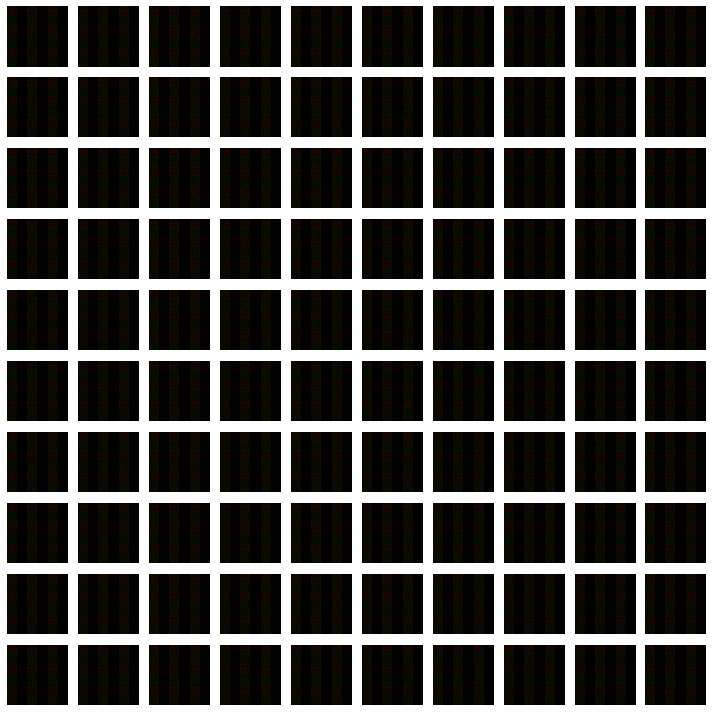

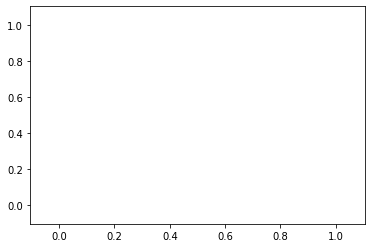

Epoch:  0  Average Discriminator Loss:  0.07434127829037607  Average Generator Loss:  0.01803593989689034
Epoch:  1  Average Discriminator Loss:  0.025691555871162564  Average Generator Loss:  0.0001449117478387052
Epoch:  2  Average Discriminator Loss:  0.024317139643244445  Average Generator Loss:  7.815903109076316e-05


KeyboardInterrupt: 

In [23]:
gloss=[]
dloss=[]

for i in tqdm_notebook(range(n_epochs)):

    gen_loss=0
    disc_loss=0

    for batch in range(n_batches):

        #Training the Discriminator:
        random_idx=np.random.randint(0,imgs.shape[0],size=int(batch_size/2))
        real_imgs=imgs[random_idx]
        real_labels=np.ones(int(batch_size/2))*0.9

        noise=np.random.normal(0,1,size=(int(batch_size/2),noise_dim))
        fake_imgs=gen.predict(noise)
        fake_labels=np.zeros(int(batch_size/2))

        total_imgs=np.vstack((real_imgs,fake_imgs))
        total_labels=np.hstack((real_labels,fake_labels))

        disc_loss+=disc.train_on_batch(total_imgs,total_labels)

        #Training the Generator:
        noise=np.random.normal(0,1,size=(batch_size,noise_dim))
        labels=np.ones(batch_size)

        gen_loss+=model.train_on_batch(noise,labels)

    if i%10==0:
        show_imgs()
        e=np.arange(i)
        plt.plot(e,gloss,c="g")
        plt.plot(e,dloss,c="r")

        plt.show()

    print("Epoch: ",i," Average Discriminator Loss: ",disc_loss/batch_size," Average Generator Loss: ",gen_loss/batch_size)

    gloss.append(gen_loss/batch_size)
    dloss.append(disc_loss/batch_size)

    if i>0 and gloss[-2]>gloss[-1]:
        gen.save(parent_dir+"deep_conv_gan_lfw.h5")

In [ ]:
e=np.arange(109)
#plt.plot(e,gloss,c="g")
plt.plot(e,dloss,c="r")

plt.show()

In [ ]:
e=np.arange(109)
plt.plot(e,gloss,c="g")
#plt.plot(e,dloss,c="r")

plt.show()